In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.stats import rv_continuous
from scipy.special import gamma
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad, simps
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
import warnings
from matplotlib.colors import LogNorm
from wkbl.particle import capture as ca

warnings.filterwarnings('ignore')

### using   /home/arturo/Documents/git/notebooks-wkbl/Theory/input.dm  as inputs


In [3]:
path = "/data/OWN/SF1test/SF0/output_00041"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
mySF0 = wkbl.Galaxy_Hound(path)
print "centering"
zoom_reg = np.where(mySF0.dm.mass == mySF0.dm.mass.min())
nucenter = nbe.real_center(mySF0.dm.pos3d[zoom_reg], mySF0.dm.mass[zoom_reg])
mySF0.center_shift(nucenter)
mySF0.r_virial(600)
print "done r200 = {0}".format(mySF0.r200)
mySF0.redefine(2.5)

loading Dark matter..
loading Stars..
loading Gas..
centering
| r_200 = 230.2734375
---- taking particles inside 2.5 * r200
| number of praticles inside 2.5 * r200 
| dm mass       =  1.439e+12 M_sun
| p_dm_200      =  9.267e+05 particles
| stellar mass  =  1.022e+11 M_sun
| p_st_200      =  4.403e+05 psrticles
| gas mass      =  1.700e+11 M_sun
| p_gs_200      =  2.323e+06 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |17, 0, 0|
| D =| 0,16, 0|
|    | 0, 0, 1|
done r200 = 230.2734375


In [4]:
path = "/data/OWN/paramstest/e01_t20/output_00041"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myhydro = wkbl.Galaxy_Hound(path)
print "centering"
zoom_reg = np.where(myhydro.dm.mass == myhydro.dm.mass.min())
nucenter = nbe.real_center(myhydro.dm.pos3d[zoom_reg], myhydro.dm.mass[zoom_reg])
myhydro.center_shift(nucenter)
myhydro.r_virial(600)
print "done r200 = {0}".format(myhydro.r200)
myhydro.redefine(2.5)

loading Dark matter..
loading Stars..
loading Gas..
centering
| r_200 = 231.4453125
---- taking particles inside 2.5 * r200
| number of praticles inside 2.5 * r200 
| dm mass       =  1.442e+12 M_sun
| p_dm_200      =  9.289e+05 particles
| stellar mass  =  1.318e+11 M_sun
| p_st_200      =  4.688e+06 psrticles
| gas mass      =  1.412e+11 M_sun
| p_gs_200      =  2.091e+06 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |22, 0, 0|
| D =| 0,20, 0|
|    | 0, 0, 1|
done r200 = 231.4453125


In [5]:
def gen_MAXW(v,v_0,al):
    return v**2*np.exp(-(v**2/v_0**2)**al)

def maxw(v,v_0):
    return v**2*np.exp(-(v**2/v_0**2))

def tsallis(v,v_0,q,N0):
    return (1./N0)* v**2 * (1.-(1.-q)*(v**2.)/(v_0**2))**(q/(1.-q))

In [21]:
hyd_sun = (myhydro.dm.r>7)&(myhydro.dm.r<9) 
dataSF1 = myhydro.dm.v[hyd_sun]
hyd_sun = (mySF0.dm.r>7)&(mySF0.dm.r<9) 
dataSF0 = mySF0.dm.v[hyd_sun]

In [22]:
maxwellian = probfit.Extended(maxw)
chi2 = probfit.BinnedChi2(maxwellian, dataSF1)
sm_sf1 = iminuit.Minuit(chi2,v_0=200,print_level=0)
sm_sf1.migrad();
generalized_maxwellian = probfit.Extended(gen_MAXW)
chi2 = probfit.BinnedChi2(generalized_maxwellian, dataSF1)
gm_sf1 = iminuit.Minuit(chi2, al=1,v_0=200, pedantic=False,print_level=0)
gm_sf1.migrad();

In [23]:
maxwellian = probfit.Extended(maxw)
chi2 = probfit.BinnedChi2(maxwellian, dataSF0)
sm_sf0 = iminuit.Minuit(chi2,v_0=200,print_level=0)
sm_sf0.migrad();
generalized_maxwellian = probfit.Extended(gen_MAXW)
chi2 = probfit.BinnedChi2(generalized_maxwellian, dataSF0)
gm_sf0 = iminuit.Minuit(chi2, al=1,v_0=200, pedantic=False,print_level=0)
gm_sf0.migrad();

In [26]:
print "      SF0"
print "generalized maxwellian"
print gm_sf0.values
print "standard maxwellian"
print sm_sf0.values
print "      SF1"
print "generalized maxwellian"
print gm_sf1.values
print "standard maxwellian"
print sm_sf1.values

      SF0
generalized maxwellian
{'v_0': 331.69538231554475, 'al': 1.7299120810706716, 'N': 0.00132767391738605}
standard maxwellian
{'v_0': 238.06653054043306, 'N': 0.0024390368308697397}
      SF1
generalized maxwellian
{'v_0': 342.1791039249151, 'al': 1.823426240100898, 'N': 0.0011577605337775468}
standard maxwellian
{'v_0': 235.77632236431674, 'N': 0.0023375513805516364}


In [33]:
myv = np.linspace(10,544,50)
gm0= gen_MAXW(myv,gm_sf0.values["v_0"],gm_sf0.values["al"])
sm0= maxw(myv,sm_sf0.values["v_0"])
N_gm0 = simps(gm0,myv)
N_sm0 = simps(sm0,myv)

gm1= gen_MAXW(myv,gm_sf1.values["v_0"],gm_sf1.values["al"])
sm1= maxw(myv,sm_sf1.values["v_0"])
N_gm1 = simps(gm1,myv)
N_sm1 = simps(sm1,myv)

h0 = np.histogram(dataSF0, bins=myv,normed=True)
center0 = (h0[1][:-1]+h0[1][1:])/2.
width0 = h0[1][1]-h0[1][0]
part_n0 = len(dataSF0)
scale0= width0*part_n0

h1 = np.histogram(dataSF1, bins=myv,normed=True)
center1 = (h1[1][:-1]+h1[1][1:])/2.
width1 = h1[1][1]-h1[1][0]
part_n1 = len(dataSF1)
scale1= width1*part_n1



<IPython.core.display.Javascript object>


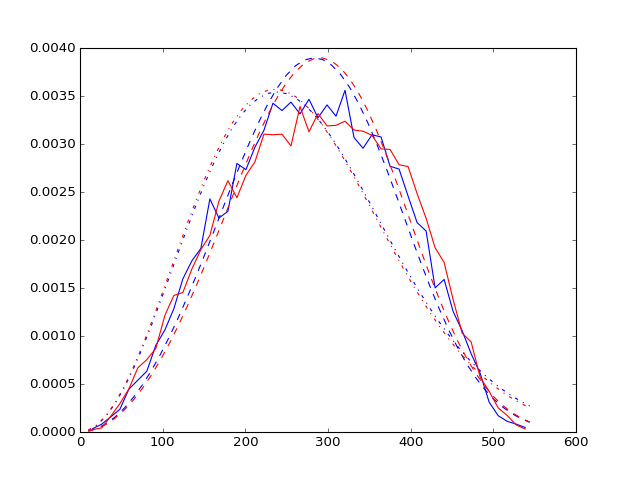

In [34]:

fig, ax= plt.subplots()
ax.plot(center0,h0[0],"b-")
ax.plot(myv,gm0/N_gm0,"b--")
ax.plot(myv,sm0/N_sm0,"b-.")

ax.plot(center1,h1[0],"r-")
ax.plot(myv,gm1/N_gm1,"r--")
ax.plot(myv,sm1/N_sm1,"r-.")


In [35]:
def transform(x,u,v_0,al):
        """
        this is the galilean transformations that correspoo
nds to the
        expression 2.2  in the CHOI paper; the part insidee
 the integral
        """
        v_S = 220.
        v = sqrt((u**2) + (v_S**2) + (2 * u * v_S * x))
        re = np.exp(-(v**2./v_0**2.)**al)
        if  not np.isfinite(re):
            return 0
        else:
            return re 


def integ(v,v_0,al,n):
    return v*quad(transform,-1.,1.,args=(v,v_0,al))[0]/n
get_it = np.vectorize(integ)

<IPython.core.display.Javascript object>


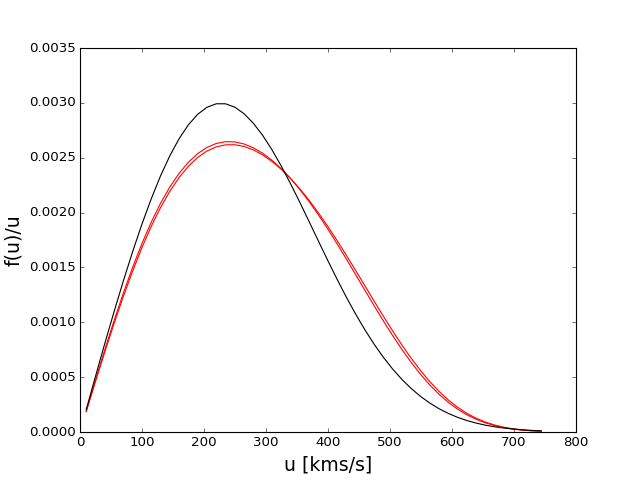

(0, 0.0035)

In [38]:
v = np.linspace(10,744,50)
shm_sun = get_it(v,220,1,1)
N_shm = simps(shm_sun,v)
shm_sun = get_it(v,220,1,N_shm)

gm_sun0 = get_it(v,gm_sf0.values["v_0"],gm_sf0.values["al"],1)
N_gm0 = simps(gm_sun0,v)
gm_sun0 = get_it(v,gm_sf0.values["v_0"],gm_sf0.values["al"],N_gm0)

gm_sun1 = get_it(v,gm_sf1.values["v_0"],gm_sf1.values["al"],1)
N_gm1 = simps(gm_sun1,v)
gm_sun1 = get_it(v,gm_sf1.values["v_0"],gm_sf1.values["al"],N_gm1)


fig, ax =plt.subplots()
ax.plot(v,gm_sun0,"r",label="classic SF")
ax.plot(v,gm_sun1,"r",label="turbulent SF")

ax.plot(v,shm_sun,"k",label="Usual assumption")
ax.set_xlabel('u [kms/s]',fontsize=17 )
ax.set_ylabel('f(u)/u',fontsize=17 )
ax.set_ylim([0,0.0035])

In [71]:
array = []
array2 = []
x_array = np.logspace(0.1, 4, num=500)
#x_array = np.append(x_array, 10000)
final = 220+544
print final
x = np.arange(0.1,final)

def inside_int(u,m,v_0,al,n):
        va = get_it(u,v_0,al,n)
        va2 = ca.caprate_GOU(u, m)#, rms=str(f)[10])
        if va2 < 0:
                va2 = 1e-15
        return va * va2
prod = np.vectorize(inside_int)

def product(m,v_0,al,n):
    """
    the producto to be inside the integral
    """ 
    array = prod(m,x,v_0,al,n)
    final =simps(array,x)
    return final



764


In [43]:
func = np.vectorize(product)
gm_cap0 = func(x_array,gm_sf0.values["v_0"],gm_sf0.values["al"],N_gm0)
gm_cap1 = func(x_array,gm_sf1.values["v_0"],gm_sf1.values["al"],N_gm1)

Shm = func(x_array,220.,1.,N_shm)


<IPython.core.display.Javascript object>


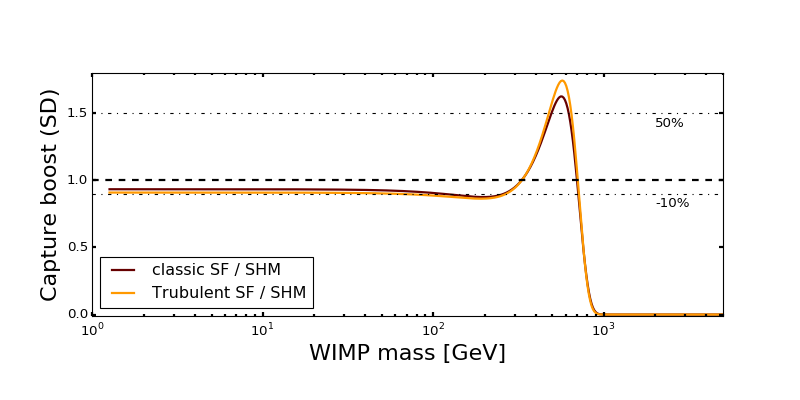

In [72]:
array0 = gm_cap0/Shm
array1 = gm_cap1/Shm

### Plotting section
fig ,ax = plt.subplots(figsize=[10,5])
fig.tight_layout(pad=5)
ax.set_xlabel('WIMP mass [GeV]',fontsize=20)
ax.set_ylabel('Capture boost (SD)',fontsize=20)
ax.set_xscale('log')
ax.set_ylim([-0.01,1.8])
ax.set_xlim([1,5000])

ax.plot(x_array, array0,c='#660000',ls='-', linewidth=2.0,
                    label='classic SF / SHM')
ax.plot(x_array, array1,c='#FF9900',ls='-', linewidth=2.0,
                    label='Trubulent SF / SHM')

ax.axhline(y=1.,c="k",ls="--",lw=2)
ax.axhline(y=0.9,c="k",ls="-.",lw=1)
ax.text(2000,0.8,"-10%")

ax.axhline(y=1.5,c="k",ls="-.",lw=1)
ax.text(2000,1.4,"50%")



legend = ax.legend(loc='lower left', shadow=False)

# The frame is matplotlib.patches.Rectangle instance surrounding the leg    end.
frame = legend.get_frame()
#fig.set_size_inches(10, 5)   
plt.tick_params(which='both', width=2)


plt.show()

Solar velocity arround GC     v_Sun =  220.0  km / s
Wimp density                    rho =  0.3  GeV / km^3 
Wimp-nucleon cross section    sigma =  5.62403697997e-06 km^2 SD Wimp-proton    
ffrom Ellis,Olive and Savage (2008) 
 proton mass                    m_p =  0.938272  GeV for SD is Hydorgen mass
Nuclear radius(depends on m_i)  r_i =  1.2e-13  ^km for hydrogen
Escape velocity               u_esc =  294.0 km / s
Dispertion velocity             v_0 =  27010000.0 km /s


<IPython.core.display.Javascript object>


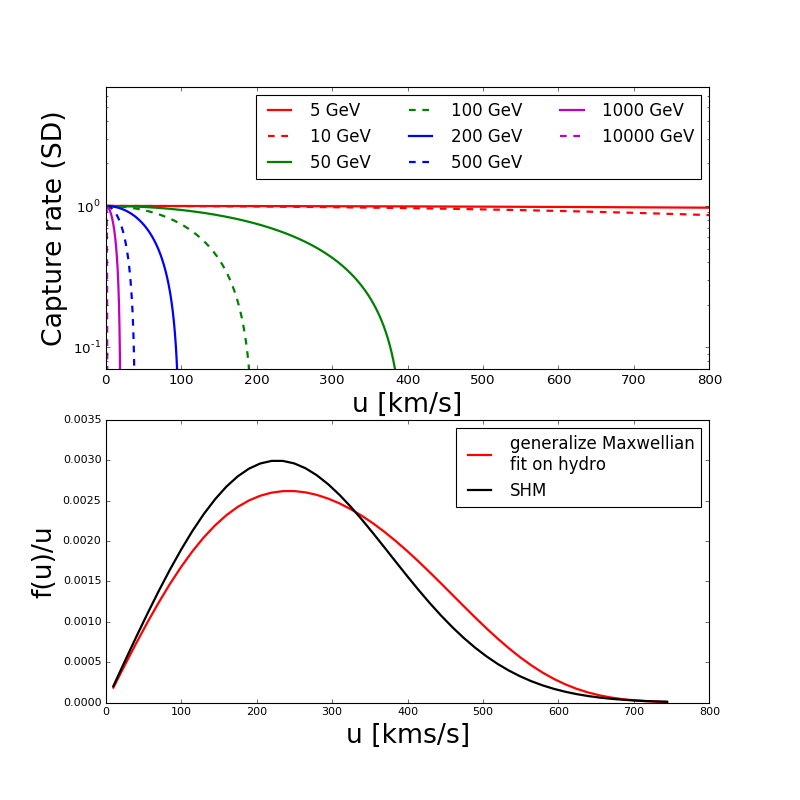

0 5
1 10
2 50
3 100
4 200
5 500
6 1000
7 10000


In [69]:
ca.get_variables() # prints variables in use (check captureLib)
### Plot parameters ###
fig ,[ax,ax1] = plt.subplots(2,1,figsize=[10,10])
fig.tight_layout(pad=6,w_pad=9,h_pad=2)
ax.set_yscale('log')
ax.set_ylim([0.07,7])
ax.set_xlabel('u [km/s]',fontsize=24)
ax.set_ylabel('Capture rate (SD)',fontsize=24)
colors = ('r-','r--', 'g-','g--', 'b-','b--', 'm-','m--', )
########################
normal=ca.normalize_max
arrays=8 * [[]]
x_array = [i for i in np.arange(1,800.,0.1)]
particle_physics = np.vectorize(ca.caprate_GOU)
masses = (5, 10, 50, 100, 200, 500, 1000, 10000)
i=-1
mins = np.array([])
for m,c in zip(masses,colors):
            i +=1
            print i, m
            arrays[i]=particle_physics(x_array,m)
            title = str(m)+' GeV'
            ax.plot(x_array, normal(arrays[i]),c, label=title,linewidth=2.0)
            y=np.abs(np.array(normal(arrays[i]))-0.05)
            x=np.array(x_array)
            mins = np.append(mins,x[(y==y.min())])

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
legend = ax.legend(loc='upper right', ncol=3, shadow=False, fontsize=15)
frame = legend.get_frame()


ax1.plot(v,gm_sun1,"r",lw=2,label="generalize Maxwellian\nfit on hydro")
ax1.plot(v,shm_sun,"k",lw=2,label="SHM")
ax1.set_xlabel('u [kms/s]',fontsize=24 )
ax1.set_ylabel('f(u)/u',fontsize=24 )
ax1.set_ylim([0,0.0035])
#for i in range(len(mins)):
#    ax1.axvline(x=mins[i],c=colors[i][0],ls=colors[i][1:],lw=2)
#    print colors[i][1:]

legend = ax1.legend(loc='upper right', ncol=1, shadow=False, fontsize=15)
frame = legend.get_frame()